# Question:



## Can we predict how well the stock market will perform based on economic indicators?

The main question can be broken down into 3 data analytics objectives:
- Compare the change in the market index over time to the changes in other economic indicators over the same time period.
- Calculate the correlation between the market index and economic indicators.
- Identify potential features for machine learning purposes.


## 1. Pre-processing the Data

### 1.1. Import All Required Modules

In [1]:
## Import all modules required for running API, Pandas and Numpy for data manipulation, 
## and Matplotlib and Seaborn for data visualisation

## Modules for API
import requests
import json
from datetime import datetime, date, time

## Pandas and Numpy
import pandas as pd
import numpy as np

## Data Visualisation Modules
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import BoundaryNorm, ListedColormap
from scipy.signal import savgol_filter


### 1.2. Setup NASDAQ & Alpha Vantage APIs 

Here, we are getting data for SP 500 value as a stock market indicator. 

We are using gold price, real GDP, unemployment rate, CPI (Consumer Price Index for inflation) and median income as economic indicators (for USA).

We are using weighted moving average, Williams' %R (WILLR) value, on balance volume (OBV) values, and the money flow index (MFI) values.

In [2]:
## API keys
nasdaq_key = "" ## API keys were deleted for privacy.
alpha_key = ""

## Time interval and symbol for techinical indicators
interval = "monthly"
symbol = "INDEX"

## URL for Stock Market Indicators (from Nasdaq)
sp500_url = f"https://data.nasdaq.com/api/v3/datasets/MULTPL/SP500_REAL_PRICE_MONTH.json?api_key={nasdaq_key}"

## URL for Economic Indicators (mostly from Nasdaq)
gold_url = f"https://www.quandl.com/api/v3/datasets/WGC/GOLD_DAILY_USD.json?api_key={nasdaq_key}"
gdp_url = f"https://www.quandl.com/api/v3/datasets/FRED/GDP.json?api_key={nasdaq_key}"
unemploy_url = f"https://www.quandl.com/api/v3/datasets/FRED/UNEMPLOY.json?api_key={nasdaq_key}"
cpi_url = f"https://www.alphavantage.co/query?function=CPI&interval=monthly&apikey={alpha_key}"
med_income_url = f"https://www.quandl.com/api/v3/datasets/FRED/MEHOINUSA672N.json?api_key={nasdaq_key}"

## URL for Technical Indicators (for SP500) from Alpha Vantage
wma_url = f"https://www.alphavantage.co/query?function=WMA&symbol={symbol}&interval={interval}&time_period=30&series_type=open&apikey={alpha_key}"
willr_url = f"https://www.alphavantage.co/query?function=WILLR&symbol={symbol}&interval={interval}&time_period=30&apikey={alpha_key}"
obv_url = f"https://www.alphavantage.co/query?function=OBV&symbol={symbol}&interval={interval}&time_period=30&apikey={alpha_key}"
mfi_url = f"https://www.alphavantage.co/query?function=MFI&symbol={symbol}&interval={interval}&time_period=30&apikey={alpha_key}"

In [3]:
## Connect to NASDAQ and Alpha Vantage APIs and request data

# apple_r = requests.get(apple_url)
sp500_r = requests.get(sp500_url)

gold_r = requests.get(gold_url)
gdp_r = requests.get(gdp_url)
unemploy_r = requests.get(unemploy_url)
cpi_r = requests.get(cpi_url)
med_income_r = requests.get(med_income_url)

wma_r = requests.get(wma_url)
willr_r = requests.get(willr_url)
obv_r = requests.get(obv_url)
mfi_r = requests.get(mfi_url)

In [2]:
## Observe the received data

# sp500_r.json()

The data from Nasdaq all have a similar dictionary structure. We need to obtain the list of data from the keys "dataset" and then "data" - the list of data are stored under the key "data".

In [1]:
# cpi_r.json()

The data from Alpha Vantage have differetn dictionary structures depending on the type of data you are requesting. The data we are interested in - "date" and "value" are stored as a sub-dictionary under the key "data". The "date" and "value" are stored as key-value pairs.

For most of the data, we are interested in only 2 columns of data: "Date", and "Value".
Some technical indicators have more than 2 columns of interest.

### 1.3. Write a function for extracting data from json format and converting to a dataframe

Because the json files from Nasdaq and Alpha Vantage are structured differently (but have a similar structure within their APIs, i.e. json files from Nasdaq have near identical structure to each other, and so do json files from Alpha Vantage), I have written two separate user functions to extract the required data from json file and convert it to a dataframe.

In [6]:
## This function extracts data from NASDAQ json file and converts to a dataframe

def getNasdaqData(r, col_name, col_name2):
    temp_json = r.json()
    temp_dict = {"date": [], col_name: []}
    
    for i in range(len(temp_json["dataset"]["data"])):
        temp_dict["date"].append(temp_json["dataset"]["data"][i][0])
        temp_dict[col_name].append(temp_json["dataset"]["data"][i][1])
    
    df = pd.DataFrame.from_dict(temp_dict)
    
    df.date = pd.to_datetime(df.date) ## Change the date datatype from string to datetime
    
    ## Calculating the change in the data value from the previous entry to the next
    df.loc[df.index[-1], col_name2] = 0 
    for i in range(len(df)- 1):
        value1 = df.iloc[i+1][col_name]
        value2 = df.iloc[i][col_name]
        change = ((value2 - value1)/value1 * 100)
        df.loc[df.index[i], col_name2] = change
    
    return df


In [7]:
## This function extracts data from Alpha Vantage json file and converts to a dataframe

def getAlphaData(r, col_name, col_name2):
    temp_json = r.json()
    temp_dict = {"date": [], col_name: []}
    
    #"CPI" data has a slightly different structure to other json files.
    if col_name == "cpi":
        for i in range(len(temp_json["data"])):
            temp_dict["date"].append(temp_json["data"][i]["date"])
            temp_dict[col_name].append(float(temp_json["data"][i]["value"]))
        
        df = pd.DataFrame.from_dict(temp_dict)
        
        df.date = pd.to_datetime(df.date) ## Change the date datatype from string to datetime
        
        ## Calculating the change in the data value from the previous entry to the next
        df.loc[df.index[0], col_name2] = 0
        for i in range(len(df)- 1):
            value1 = df.iloc[i+1][col_name]
            value2 = df.iloc[i][col_name]
            change = ((value2 - value1)/value1 * 100)
            df.loc[df.index[i], col_name2] = change
        return df
    
    else: ## If the data is a technical indicator:    
        temp_name = f"{col_name.upper()}"
        temp_col_name = f"Technical Analysis: {temp_name}"
        
        for key, value in temp_json[temp_col_name].items():
            temp_dict["date"].append(key)
            temp_dict[col_name].append(float(value[temp_name]))
        
        df = pd.DataFrame.from_dict(temp_dict)
        
        df.date = pd.to_datetime(df.date) ## Change the date datatype from string to datetime
        
        ## We are not interested in changes in value for technical indicators.
        return df

In [8]:
## Use the functions to convert to dataframes

sp500_df = getNasdaqData(sp500_r, "sp500", "sp500_change")

gold_df = getNasdaqData(gold_r, "gold", "gold_change")
gdp_df = getNasdaqData(gdp_r, "gdp", "gdp_change")
unemploy_df = getNasdaqData(unemploy_r, "unemploy", "unemploy_change")
cpi_df = getAlphaData(cpi_r, "cpi", "cpi_change")
med_income_df = getNasdaqData(med_income_r, "med_income", "med_income_change")

wma_df = getAlphaData(wma_r, "wma", "wma_change")
willr_df = getAlphaData(willr_r, "willr", "willr_change")
obv_df = getAlphaData(obv_r, "obv", "obv_change")
mfi_df = getAlphaData(mfi_r, "mfi", "mfi_change")

## Store the dataframe names into a list for any for loops blocks
df_list = [sp500_df, gold_df, gdp_df, unemploy_df, cpi_df, med_income_df] 
# Because technical indicators are only available from 2015 up to 2017, I chose not to use these data for my analysis.


In [9]:
sp500_df ## Checking the resulting dataframe

,date,sp500,sp500_change
0,2022-08-31,3955.00,-4.511500
1,2022-08-01,4141.86,5.883075
2,2022-07-01,3911.73,3.337842
3,2022-06-30,3785.38,-2.912836
4,2022-06-01,3898.95,-5.643551
...,...,...,...
1840,1871-05-01,4.86,2.531646
1841,1871-04-01,4.74,2.819957
1842,1871-03-01,4.61,2.444444
1843,1871-02-01,4.50,1.351351


## 2. Data Cleaning & Manipulation

We first need to inspect the dataframes to ensure all the data are a proper type (i.e. datetype for dates and floats for values), and check how many empty values there are.

There will be a few empty values since each data are in different time intervals.

### 2.1. Inspect dataframes

In [10]:
for df in df_list:
    print(f"\n")
    print(df.head())
    print(df.tail())
    print(f"\n")
    print(df.info())



        date    sp500  sp500_change
0 2022-08-31  3955.00     -4.511500
1 2022-08-01  4141.86      5.883075
2 2022-07-01  3911.73      3.337842
3 2022-06-30  3785.38     -2.912836
4 2022-06-01  3898.95     -5.643551
           date  sp500  sp500_change
1840 1871-05-01   4.86      2.531646
1841 1871-04-01   4.74      2.819957
1842 1871-03-01   4.61      2.444444
1843 1871-02-01   4.50      1.351351
1844 1871-01-01   4.44      0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1845 entries, 0 to 1844
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1845 non-null   datetime64[ns]
 1   sp500         1845 non-null   float64       
 2   sp500_change  1845 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 43.4 KB
None


        date     gold  gold_change
0 2020-03-13  1562.80    -0.502960
1 2020-03-12  1570.70    -5.021920
2 2020-03-11  1653.75    -0.11

Notice that each dataframe has different start and end dates.
Also, SP500 value and economic indicators are either recorded monthly, quarterly or yearly, unlike the gold prices which is recorded daily.
When we combine these dataframes into a single dataframe, this will create null values.

### 2.2. Concatenate all dataframes into a single dataframe

First, we need to change the index for each dataframe from the default index in interger format to date column.
The date index will be used to concatenate all dataframes into a single dataframe according to the date.

In [11]:
## Set the index for each dataframe to date column

for df in df_list:
    df.set_index("date", inplace = True)


In [12]:
df = pd.concat([gold_df, gdp_df, unemploy_df, cpi_df, med_income_df, sp500_df], axis = 1)

print(df.info())
print(f"\n Number of null values in each column: \n")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12252 entries, 1871-01-01 to 2022-08-31
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gold               10787 non-null  float64
 1   gold_change        10787 non-null  float64
 2   gdp                300 non-null    float64
 3   gdp_change         300 non-null    float64
 4   unemploy           889 non-null    float64
 5   unemploy_change    889 non-null    float64
 6   cpi                1315 non-null   float64
 7   cpi_change         1314 non-null   float64
 8   med_income         37 non-null     float64
 9   med_income_change  37 non-null     float64
 10  sp500              1845 non-null   float64
 11  sp500_change       1845 non-null   float64
dtypes: float64(12)
memory usage: 1.2 MB
None

 Number of null values in each column: 

gold                  1465
gold_change           1465
gdp                  11952
gdp_change           11952
unempl

As mentioned earlier, there are significant number of null values, especially for economic indicators.
We will use a combination of forward fill and backward fill methods to replace the null values.
(We could use other methods such as moving average values, but the chosen method is the simplest way to replace the null values without affecting the overall trend in the data)

In [13]:
df = df.fillna(method = "ffill")
df = df.fillna(method = "bfill")

df.isnull().sum() ## Check to see if all null values have been replaced.

gold                 0
gold_change          0
gdp                  0
gdp_change           0
unemploy             0
unemploy_change      0
cpi                  0
cpi_change           0
med_income           0
med_income_change    0
sp500                0
sp500_change         0
dtype: int64

### 2.3. Slice the dataframe to fit between start and end dates

We want to only use data from between 1 Jan 1980 to 31 Dec 2019, which is about 40 years worth of data. 

In [14]:
## Set the start and end dates, and create a mask to mask the values that are within the set dates.
start_date = "1980-1-1"
end_date = "2019-12-31"

mask = (df.index >= start_date) & (df.index <= end_date)

df = df.loc[mask]

In [15]:
df

,gold,gold_change,gdp,gdp_change,unemploy,unemploy_change,cpi,cpi_change,med_income,med_income_change,sp500,sp500_change
date,,,,,,,,,,,,
1980-01-01,512.00,0.000000,2789.842,2.421506,6683.0,5.660079,77.800,1.434159,53337.0,0.000000,110.90,2.875696
1980-01-02,559.50,9.277344,2789.842,2.421506,6683.0,5.660079,77.800,1.434159,53337.0,0.000000,110.90,2.875696
1980-01-03,634.00,13.315460,2789.842,2.421506,6683.0,5.660079,77.800,1.434159,53337.0,0.000000,110.90,2.875696
1980-01-04,588.00,-7.255521,2789.842,2.421506,6683.0,5.660079,77.800,1.434159,53337.0,0.000000,110.90,2.875696
1980-01-07,633.50,7.738095,2789.842,2.421506,6683.0,5.660079,77.800,1.434159,53337.0,0.000000,110.90,2.875696
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,1482.10,0.000000,21694.458,0.880939,5861.0,-1.163575,256.974,-0.090977,69560.0,6.806701,3176.75,2.314084
2019-12-26,1482.10,0.000000,21694.458,0.880939,5861.0,-1.163575,256.974,-0.090977,69560.0,6.806701,3176.75,2.314084
2019-12-27,1511.50,1.983672,21694.458,0.880939,5861.0,-1.163575,256.974,-0.090977,69560.0,6.806701,3176.75,2.314084


## 3. Exploratory Data Analysis

### 3.1. Plot graphs for each column for visualisation

Here, we will use simple line graphs to visualise what the data in each column looks like.
We are using a line graph because we are dealing with time-series data.

#### 3.1.1 Define user functions for plotting graphs

We will first create a user function for plotting graphs.

In [16]:
def linegraph(col_names):
    sns.set_palette("pastel")
    sns.set(rc={'axes.facecolor':sns.xkcd_rgb["white"], 
            'figure.facecolor':'white'})
    
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f"Time vs {col_names[0].title()} and {col_names[1].title()} from 1980 to 2020",
                  fontsize = 20)
    
    for i in range(len(col_names)):
        x = mdates.date2num(df.index)
        y = df[col_names[i]].values
        
        sns.set(font_scale = 1)
        sns.lineplot(ax=axes[i],
                     x=df.index, 
                     y=col_names[i], 
                     data = df,
                     alpha = 0.7,
                     linewidth = 3)
        
        if i == 0:
            yhat = savgol_filter(y, 701, 2)
            sns.lineplot(ax=axes[i],
                         x=df.index,
                         y=yhat,
                         data = df,
                         color = 'red',
                         alpha = 0.4,
                         linewidth = 2)
        
        else:
            yhat = savgol_filter(y, 701, 5)
            sns.lineplot(ax=axes[i],
                         x=df.index,
                         y=yhat,
                         data = df,
                         color = 'red',
                         alpha = 0.7,
                         linewidth = 2)
        
        axes[i].xaxis.set_major_locator(mdates.YearLocator(base=10))
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    
        axes[i].grid(alpha = 0.7, color='gray')
        axes[i].set_xlabel(f"Date (Year)", fontsize = 14)
        axes[i].set_ylabel(f"{col_names[i].title()}", fontsize = 14)
    plt.show() 
    print(f"EDA for {col_names}: \n", f"\n{df[col_names].describe()} \n")

### Line Plots of Each Variables over Time

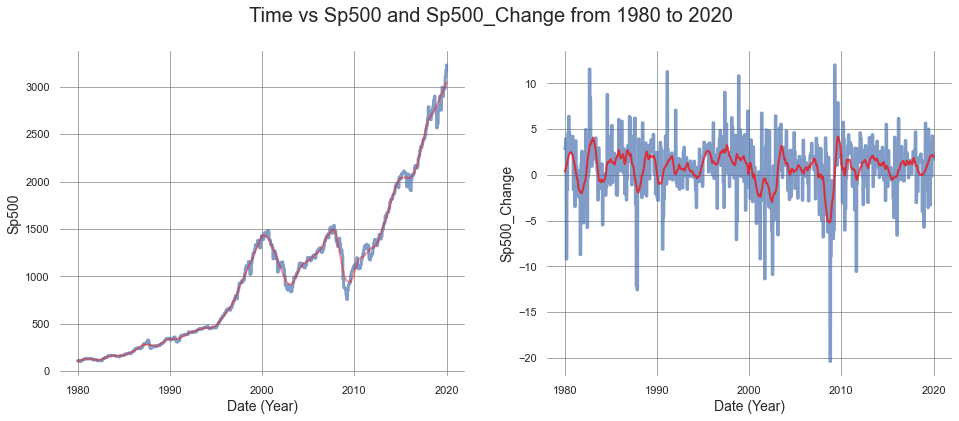

EDA for ['sp500', 'sp500_change']: 
 
              sp500  sp500_change
count  10573.000000  10573.000000
mean    1000.351265      0.772526
std      744.263834      3.517416
min      103.000000    -20.391142
25%      330.750000     -0.829187
50%      989.530000      1.030353
75%     1378.760000      2.924901
max     3230.580000     12.021714 



In [17]:
## Plot SP500 and Change in SP500

linegraph(["sp500", "sp500_change"])


Observations:
- SP500 value has gradually increased from 1980 to 2020.
- There was a steep growth in value at around from mid-1990 and again from around 2010. 
- The growth in mid-1990 is most likely due to the dot-com bubble and its subsequent crash in 2000.
- There was a sudden decline at around 2007, which is due to the global financial crisis. At its peak, the market value dropped by -20% (see the right graph).
- The market has started to recover since then and increased in value.


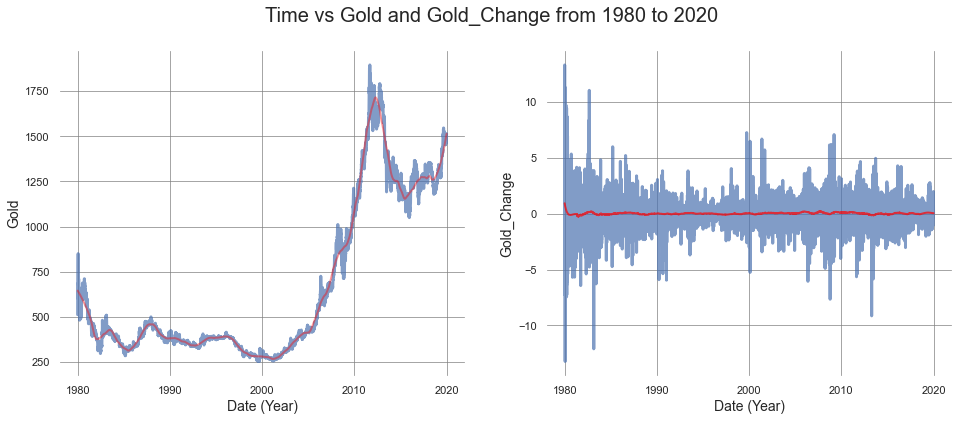

EDA for ['gold', 'gold_change']: 
 
               gold   gold_change
count  10573.000000  10573.000000
mean     659.402491      0.017553
std      431.304628      1.164541
min      252.800000    -13.235294
25%      353.000000     -0.461775
50%      412.400000      0.000000
75%     1081.500000      0.497454
max     1895.000000     13.315460 



In [18]:
## Plot gold price and its change over time

linegraph(["gold", "gold_change"])

Observations:
- The price of gold remained relatively stable from the mid-1980 to 2000, and then began to rapidly increase in value since 2000.
- Paper currencies have a tendency to lose value over time. The sudden increase in gold since 2000 is an indicator that economic condition during that time was not favourable for investors so they were forced look to gold for its perceived safety and its potential as a hedge against declining currency values. 
- The price of gold fluctuated between around +/- 5% during the period.

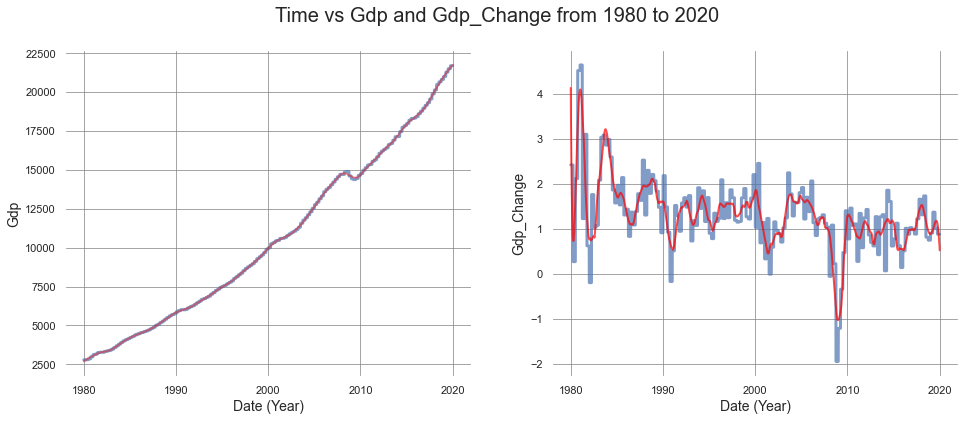

EDA for ['gdp', 'gdp_change']: 
 
                gdp    gdp_change
count  10573.000000  10573.000000
mean   10578.293301      1.308749
std     5420.965935      0.803778
min     2789.842000     -1.951749
25%     5872.701000      0.898704
50%    10002.179000      1.243545
75%    14898.999000      1.691958
max    21694.458000      4.643991 



In [19]:
## Plot gdp price and its change over time

linegraph(["gdp", "gdp_change"])

Observations:
- GDP in the US gradually rose almost linearly.
- The only instance when the GDP decreased was in 2007 during the global financial crisis, when it decreased by almost -2%. This is an indicator that the economy was in recession (GDP typically declines by -2% during recession).

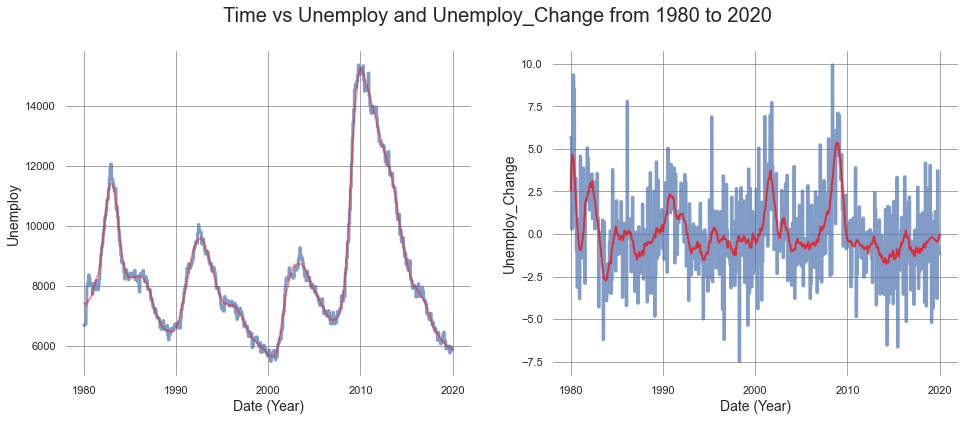

EDA for ['unemploy', 'unemploy_change']: 
 
           unemploy  unemploy_change
count  10573.000000     10573.000000
mean    8471.168826         0.018435
std     2261.611875         2.623581
min     5481.000000        -7.489879
25%     6892.000000        -1.757232
50%     7980.000000        -0.083638
75%     9029.000000         1.440894
max    15352.000000         9.925363 



In [20]:
## Plot unemployment and its change over time

linegraph(["unemploy", "unemploy_change"])

Observations:
- The unemployment rate shows almost cyclic pattern that increases and decreases every 10 years.
- Again, the only time when this 10 year cycle was broken was during the global financial crisis, causing the unemployment rate to reach its peak at 14,000,000 (approx. 10% increase from previous year).
- Since then, the unemployment level has rapidly declined, indicating the economy and the job market has improved.

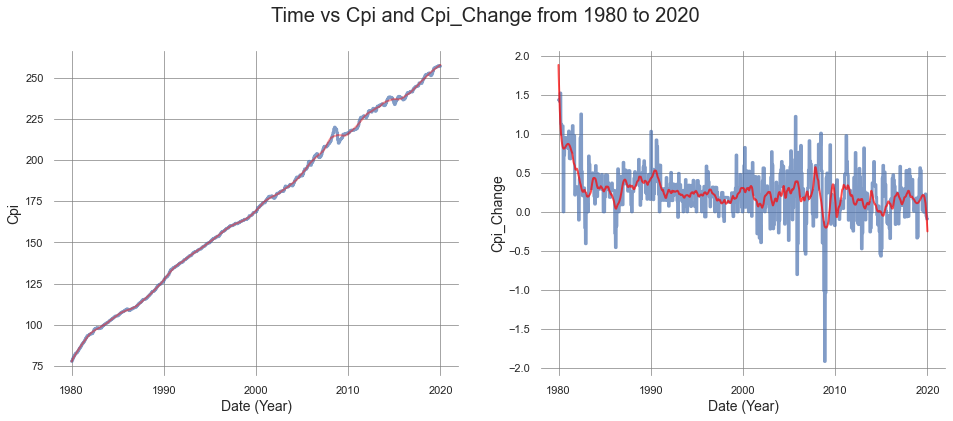

EDA for ['cpi', 'cpi_change']: 
 
                cpi    cpi_change
count  10573.000000  10573.000000
mean     171.326814      0.251771
std       50.886441      0.346400
min       77.800000     -1.915290
25%      127.400000      0.067843
50%      168.800000      0.241741
75%      218.009000      0.440019
max      257.346000      1.520913 



In [21]:
## Plot CPI and its change over time

linegraph(["cpi", "cpi_change"])

Observations:
- CPI, or Consumers Price Index, is a measure of inflation. High value indicates higher inflation.
- The data indicates that inflation has always continued to rise (i.e. it NEVER declined).

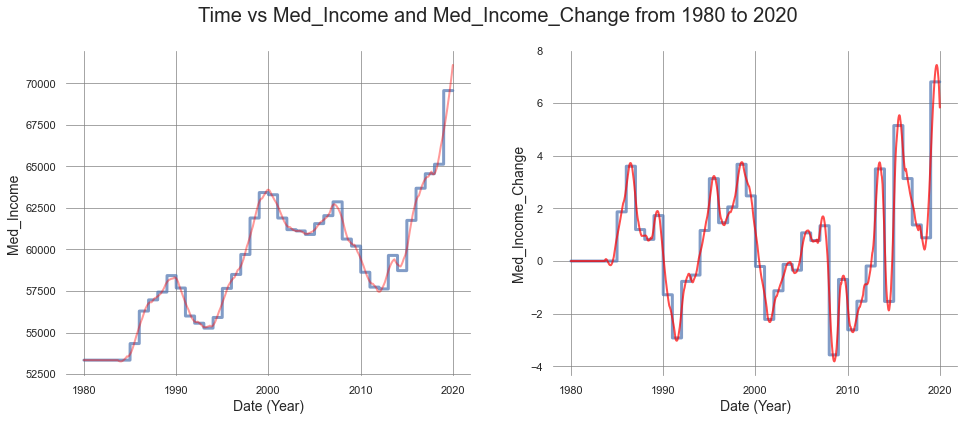

EDA for ['med_income', 'med_income_change']: 
 
         med_income  med_income_change
count  10573.000000       10573.000000
mean   59108.796463           0.688177
std     3742.667835           2.139049
min    53337.000000          -3.564782
25%    56291.000000          -0.699393
50%    58725.000000           0.000000
75%    61748.000000           1.727230
max    69560.000000           6.806701 



In [22]:
## Plot median income and its change over time

linegraph(["med_income", "med_income_change"])

Observations:
- The average median income in the US during 1980 to 2020 is around USD 59,000.
- The median income has continued to increase since 2010, and it has reached its peak at USD 69,560 in 2020.
- The median income rapidly declined only on two occasions: in 1990 (due to the recession) and in 2007 (global financial crisis).

### Normalised Line Plots for Comparing Economic Indicator Variables to SP500

Here, I have normalised the dataset so I can compare the data that are in different units and scales

In [23]:
norm_df=(df-df.min())/(df.max()-df.min())
norm_df

,gold,gold_change,gdp,gdp_change,unemploy,unemploy_change,cpi,cpi_change,med_income,med_income_change,sp500,sp500_change
date,,,,,,,,,,,,
1980-01-01,0.157837,0.498490,0.0,0.663042,0.121771,0.755083,0.000000,0.974753,0.0,0.34371,0.002526,0.717827
1980-01-02,0.186762,0.847910,0.0,0.663042,0.121771,0.755083,0.000000,0.974753,0.0,0.34371,0.002526,0.717827
1980-01-03,0.232128,1.000000,0.0,0.663042,0.121771,0.755083,0.000000,0.974753,0.0,0.34371,0.002526,0.717827
1980-01-04,0.204116,0.225220,0.0,0.663042,0.121771,0.755083,0.000000,0.974753,0.0,0.34371,0.002526,0.717827
1980-01-07,0.231823,0.789936,0.0,0.663042,0.121771,0.755083,0.000000,0.974753,0.0,0.34371,0.002526,0.717827
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,0.748569,0.498490,1.0,0.429472,0.038497,0.363262,0.997928,0.530910,1.0,1.00000,0.982789,0.700501
2019-12-26,0.748569,0.498490,1.0,0.429472,0.038497,0.363262,0.997928,0.530910,1.0,1.00000,0.982789,0.700501
2019-12-27,0.766472,0.573203,1.0,0.429472,0.038497,0.363262,0.997928,0.530910,1.0,1.00000,0.982789,0.700501


## 4. Data Analysis Specific to Project Objectives

### Q1. Compare the change in the market index over time to the changes in other economic indicators over the same time period.

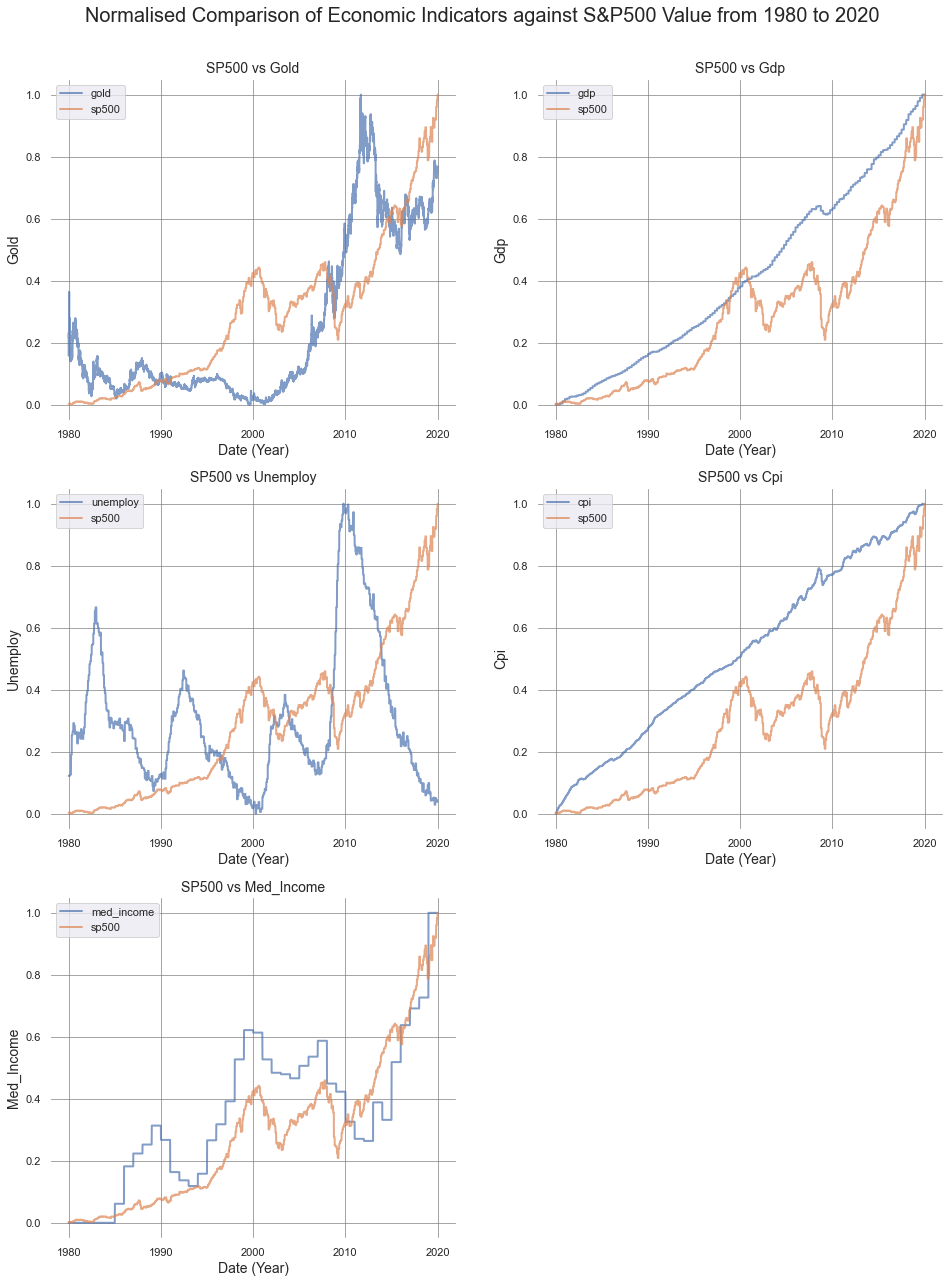

In [24]:
## For loop for creating 5 different plots comparing economic indicators against SP500 value.

col_names = ["gold", "gdp", "unemploy", "cpi", "med_income"]

sns.set_palette("pastel")
sns.set(rc={'axes.facecolor':sns.xkcd_rgb["white"], 
        'figure.facecolor':'white'})

fig, axes = plt.subplots(3, 2, figsize=(16, 20))
fig.suptitle(f"Normalised Comparison of Economic Indicators against S&P500 Value from 1980 to 2020",
              fontsize = 20)

for i in range(len(col_names)):
    ax = plt.subplot(3, 2, i+1)    
    sns.set(font_scale = 1)
    sns.lineplot(ax=ax,
                 x=norm_df.index, 
                 y=col_names[i], 
                 data = norm_df,
                 alpha = .7,
                 palette=['blue'],
                 linewidth = 2,
                 label = col_names[i])
    
    sns.lineplot(ax=ax,
                 x=norm_df.index, 
                 y="sp500", 
                 data = norm_df,
                 alpha = .7,
                 palette=['red'],
                 linewidth = 2,
                 label = "sp500")
        
    ax.xaxis.set_major_locator(mdates.YearLocator(base=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    ax.grid(alpha = 0.7, color='gray')
    ax.set_xlabel(f"Date (Year)", fontsize = 14)
    ax.set_ylabel(f"{col_names[i].title()}", fontsize = 14)
    plt.title(f"SP500 vs {col_names[i].title()}", fontsize = 14)

fig.delaxes(plt.subplot(3,2,6))
plt.subplots_adjust(top = 0.93)


plt.show() 

Observations:
- Apart from unemployment rate, all other economic indicators follow the same general of positive increase and similar rate of increase (i.e. gradient) as S&P 500 value.
- When the price of gold was low, the relative value of S&P500 was high (from 1995 to 2010), and when the price of gold was high, the relative value of S&P500 was low (2010 - 2015). This suggests a possibility that when the economy is weak, the investors tend to stay away from the stock market and invest in gold, which is regarded as a safe investment.
- The unemployment level seems to be negatively correlated. For example, as the unemployment level drops, the market value increases (indicating strong economy) and vice versa.
- The median income follows near identical pattern as the market index value.

### Q2. Calculate the correlation between the market index and economic indicators.

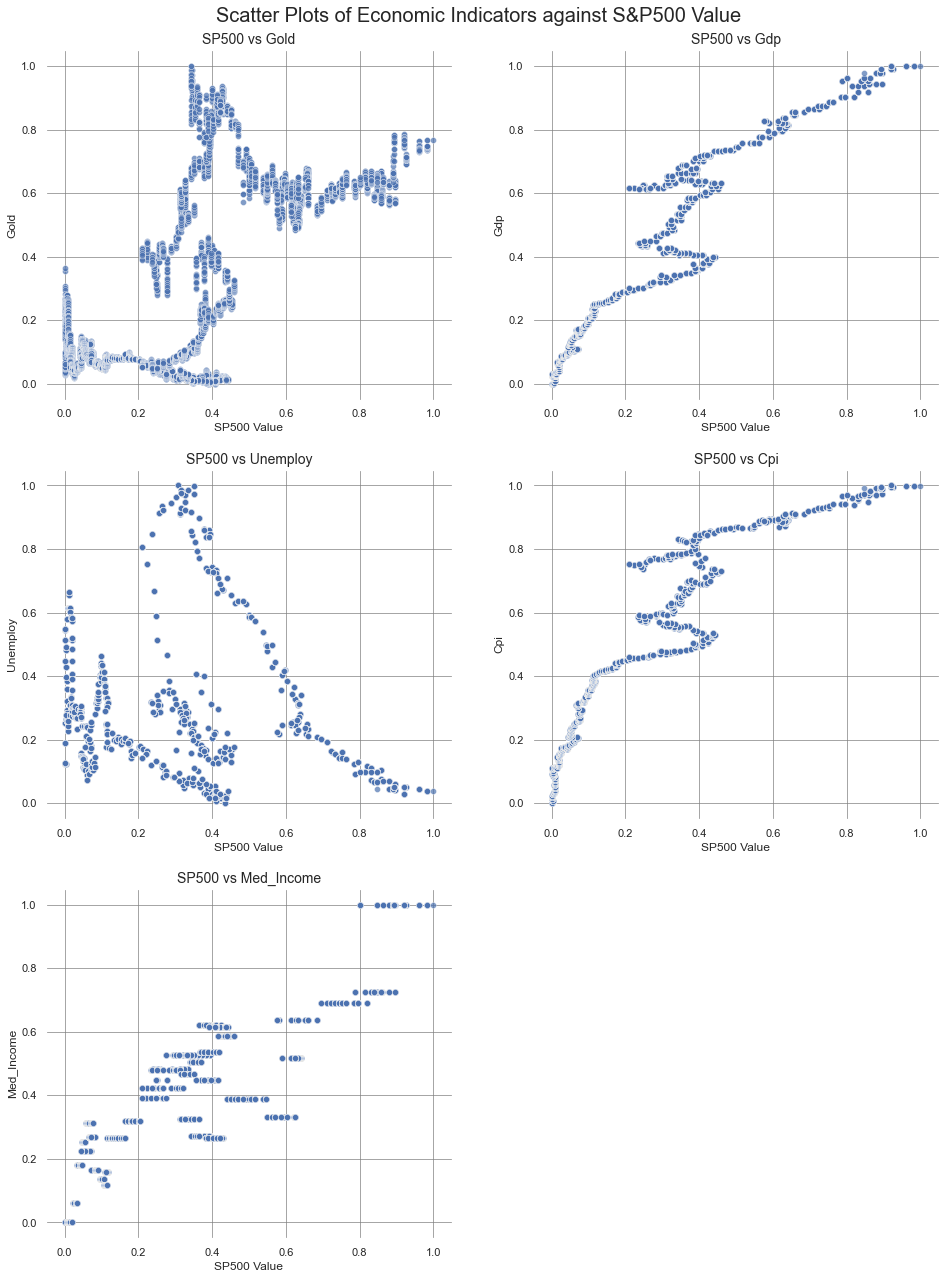

In [25]:
## Scatter Plot

col_names = ["gold", "gdp", "unemploy", "cpi", "med_income"]

sns.set_palette("pastel")
sns.set(rc={'axes.facecolor':sns.xkcd_rgb["white"], 
        'figure.facecolor':'white'})

fig, axes = plt.subplots(3, 2, figsize=(16, 20))
fig.suptitle(f"Scatter Plots of Economic Indicators against S&P500 Value",
              fontsize = 20)

for i in range(len(col_names)):
    ax = plt.subplot(3, 2, i+1)    
    sns.set(font_scale = 1)
    sns.scatterplot(ax=ax,
                    x="sp500", 
                    y=col_names[i], 
                    data = norm_df,
                    alpha = .7)

    ax.grid(alpha = 0.7, color='gray')
    ax.set_xlabel(f"SP500 Value", fontsize = 12)
    ax.set_ylabel(f"{col_names[i].title()}", fontsize = 12)
    plt.title(f"SP500 vs {col_names[i].title()}", fontsize = 14)

fig.delaxes(plt.subplot(3,2,6))
plt.subplots_adjust(top = 0.95)


plt.show() 

In [26]:
## C0rrelation between factors.
col_names = ["gold", "gdp", "unemploy", "cpi", "med_income", "sp500"]


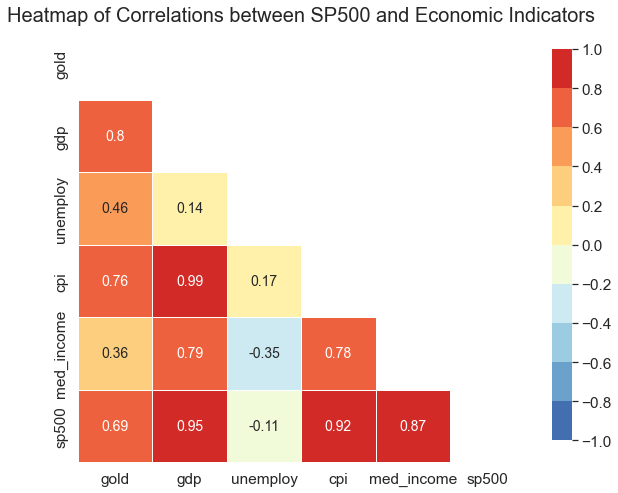

In [27]:
mask = np.zeros_like(df[col_names].corr())
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10,8))

    my_colors = sns.color_palette("RdYlBu_r", 10)
    my_cmap = ListedColormap(my_colors)
    bounds = np.linspace(-1,1,11)
    my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

    plt.title("Heatmap of Correlations between SP500 and Economic Indicators", fontsize = 20)
    sns.heatmap(df[col_names].corr(),
                cmap=my_cmap,
                norm=my_norm,
                annot=True,
                annot_kws=dict(fontsize = 14),
                cbar_kws=dict(ticks=bounds, shrink=0.9, location = "right"),
                linewidths=.5,
                mask = mask)

plt.show()

Observations:
- SP500 is most strongly correlated (positively) to GDP (0.95) and CPI (0.92), followed by the median income (0.87) and gold (0.69).
- SP500 is negatively and moderately correlated to unemployment level (-0.11), reinforcing the pattern of opposite movement (i.e. increase in unemployment with decrease in SP500 value, and vice versa).
- GDP and CPI are almost perfectly correlated (0.99). Incorporating both features for supervised machine learning (i.e. linear regression model) may lead to poor predictions due to multicolinearity. 

## 5. Conclusion & Future Improvements

- Most economic indicators are strongly correlated to SP500 value and can be regarded as strong feature candidates for machine learning prediction model.
- Another indicator to use may be news feeds - using the count of keywords like "SP500" in the news outlets, and twitter to gauge the interest in the market.

- There may be a better way to fill out null values. For example, it may be possible to write a user function to fill the null values with gradually changing values determined by two consecutive non-null values rather than with a constant value using forward fill and/or backward fill.

In [28]:
## Export the dataframe as csv file for data visualisation using Tableau

df.to_csv('stockmarket_df.csv', index=True)

In [29]:
norm_df.to_csv('stockmarket_df_norm.csv', index=True)

### Appendix. Link to Tableau Presentation

https://public.tableau.com/app/profile/chang.joon.lee/viz/SP500_16620712703670/Dashboard1?publish=yes

A simple Tableau dashboard was created to test out some of the basic visualisation methods available in Tableau.